# **Project 7: Personal Data Analysis**

Partner: Gauri Vaidya

Sources:


*   [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)
*   [heatmap info](https://datavizcatalogue.com/methods/heatmap.html)



In [1]:
# Import packages
from bs4 import BeautifulSoup
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Link drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def makeChartManual(xlabel,ylabel,title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

# **Part 1: Extracting Timestamps**

For this section, I downloaded my YouTube watch history in HTML format, with each entry looking like this:
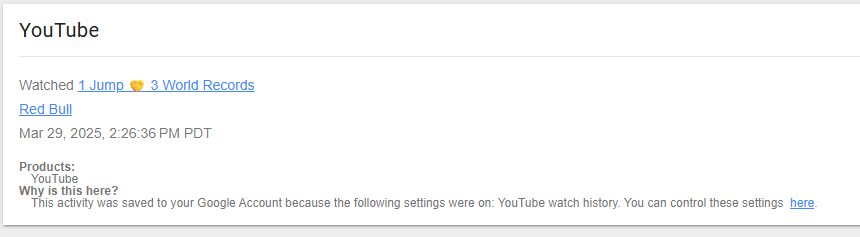

In [4]:
# Link to watch history file in Drive
history = "/content/drive/MyDrive/CS215/Project 7/watch-history.html"

In [5]:
# Temporarily open history file, parse it with beautifulsoup
with open(history, 'r', encoding='utf-8') as yt_file:
    yt_soup = BeautifulSoup(yt_file, 'lxml')
# Consolidate sections with date
date_section = yt_soup.find_all(class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1')

For the final step of extracting the timestamps, I ran into problems because the class that contained the timestamps also contained other text. I asked ChatGPT what the best way around this was. It reccomended using the re module to search for a specific format of text. It helped me figure out how to use re to extract the timestamps. While I haven't learned how to use re entirely by myself after this, my goal is to be familiar enought to know to use it in the future, solidifying my knowledge of the tool over time.

In [6]:
dates = []

for section in date_section:
    txt = section.text
    # Search for text with this specific format and sequencing of numbers and letters
    date_search = re.search(r'\w{3} \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{1,2}\s[AP]M\s[A-Z]{3}', txt)

    # Returns the searched text
    date = date_search.group()
    # Replace an irregular space character with a regular space
    date = date.replace('\u202f', ' ')
    dates.append(date)
# Create dataframe and csv with timestamps
dfK = pd.DataFrame(dates, columns=['Timestamp'])
dfK.to_csv('timestamps_kyle.csv', index=False)

# **Part 2: Timestamp Analysis**



In this section, I imported my parner's timestamp data in CSV format for analysis.

In [7]:
partner_hist = "/content/drive/MyDrive/CS215/Project 7/GV search history timestamps.csv"
dfP = pd.read_csv(partner_hist)
# Invert dataframe
dfP = dfP.iloc[::-1]

In [8]:
# Converts to datetime64 format
dfP['Timestamp'] = pd.to_datetime(dfP['Timestamp'], format='%Y-%m-%d %H:%M:%S%z')

# New column of difference between timestamp rows
dfP['deltaT'] = dfP['Timestamp'].diff()

In [9]:
# Max time difference
print(dfP['deltaT'].max())

737 days 10:19:06


In [10]:
# Average time difference
print(dfP['deltaT'].mean())

0 days 13:11:46.082706766


The maximum time between entries was 737 days, and the average was 13 hours. Given the average consistency of entries, this seems to indicate that the service was not used during those 737 days, she switched to another account, or data was lost somehow.

In [11]:
# New columns for day and month of each timestamp entry
dfP['day'] = pd.DatetimeIndex(dfP['Timestamp']).day
dfP['month'] = pd.DatetimeIndex(dfP['Timestamp']).month
dfP['hour'] = pd.DatetimeIndex(dfP['Timestamp']).hour
dfP['date'] = pd.DatetimeIndex(dfP['Timestamp']).date
dfP['year'] = pd.DatetimeIndex(dfP['Timestamp']).year

In [12]:
# Analyze frequency of each month with value counts
print(dfP['month'].value_counts())

month
12    471
8     458
1     437
6     434
5     408
7     392
3     391
2     373
11    355
10    315
4     223
Name: count, dtype: int64


Using value_counts, I can see that December is the month with the most entries, at 471. I could guess that this lines up with winter break. In keeping with this theory, January is third. The specific day with the most entries is January 15th, 2025.

In [13]:
# Dates with the most entries
print(dfP['date'].value_counts().head())

date
2025-01-15    74
2025-01-16    40
2025-02-02    38
2023-05-15    38
2023-07-28    33
Name: count, dtype: int64


**Visualization:**

To try and figure out what kind of data this is, I decided to create a heatmap that shows the frequency of entries across the hours of a day for each month in the year. I've never created a heatmap before, so I used ChatGPT to help me figure out the best way to do this using pandas.

<Axes: xlabel='month', ylabel='hour'>

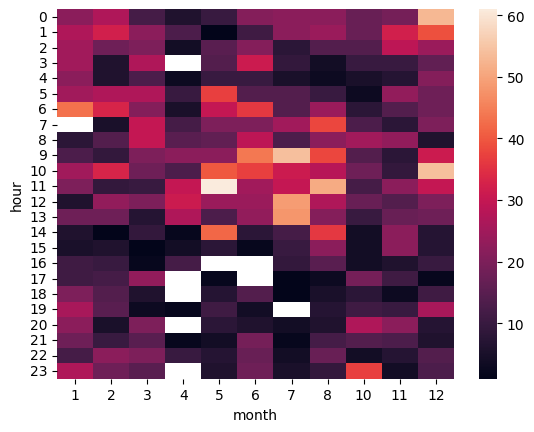

In [14]:
heatmap = dfP.groupby(['month', 'hour'])['hour'].count().reset_index(name='count')
heatmap = heatmap.pivot(index='hour', columns='month', values='count')

sns.heatmap(heatmap)

I think there are a few takeaways from this heatmap. There is consistently a lack of entries in the afternoon and evening (~2pm to 8pm). The most common hours varies across the course of the year, with morning-noon being the most common during summer months, and near-midnight being quite common during some winter months. The service also doesn't seem to be used as much during unbroken school months. During non-sumer months, the service is generally used most at night. The service is used most frequently during the summer, with most use centered near noon. Overall, these frequencies seem to indicate that the service is used during times when free time is most likely to occur.

Based on this, and the high number of entries that can occur, I think that the data is likely a search history of some sort. Doing a closer analysis of time between searches could help reveal what type of search data it is (YouTube might have more time in between searches during a period of active searching).

**Partner's Analysis:**



# **Part 3: Combined Visualization**

# **Part 4: Additional Analysis**

Questions:


*   What YouTubers have I watched the most of in total?
*   How many different YouTubers have I watched?






For the first question, I iterated through each channel name and counted the number of times it occurs in a dictionary that I sort using a lambda function.

In [15]:
youtubers = {}

# Find channel name (if applicable), count # of occurences
for section in date_section:
  links = section.find_all('a')
  try:
    channel = links[1].get_text(strip=True)
  except:
    pass
  if channel not in youtubers:
    youtubers[channel] = 1
  else:
    youtubers[channel] += 1

# Sort dictionary into a list of tuples
ytrs_sorted = sorted(youtubers.items(), key=lambda item: item[1], reverse=True)

In [16]:
# Top 10 lists for plotting
ytrs_top_0 = [entry[0] for entry in ytrs_sorted[:10]]
ytrs_top_1 = [entry[1] for entry in ytrs_sorted[:10]]

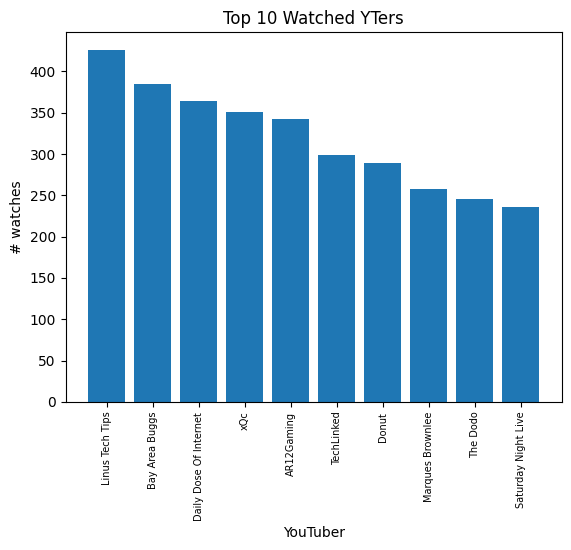

In [17]:
# Bar chart of the 10 youtubers I watched the most
plt.bar(ytrs_top_0, ytrs_top_1)
plt.xticks(rotation=90,fontsize=7)
makeChartManual('YouTuber','# watches','Top 10 Watched YTers')
plt.show()

This visualization is funny for me to see, as most of these represent different interests I had during the COVID lockdown. Surprisingly, there were no Minecraft YouTubers.

My final question is simpler to answer than the others: I wanted to know how many unique youtubers I have watched. My intuition told me it would be around a thousand at most. To my surprise, the number was almost 12000

In [18]:
# Number of unique YouTubers
num_youtubers = len(ytrs_sorted)
print(num_youtubers)

11633


For use in the shared part of section 2, I exported the analyzed data as a csv

In [ ]:
dfP.to_csv('gauri_analyzed.csv')